In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4 as nc
import seaborn as sns
import matplotlib.colors as mcolors
import glob
import os
import xarray as xr
import datetime
from salishsea_tools import viz_tools, tidetools, geo_tools
import ONC_patrols as onc

%matplotlib inline

In [2]:
nowcast = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV17-02')

In [3]:
nowcast_salinity = nowcast.salinity
nowcast_temperature = nowcast.temperature

In [4]:
grid_B_new=nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
mesh_mask_new=nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')
badQC=[0,3,4,9]

In [5]:
bathy, X, Y = tidetools.get_bathy_data(grid_B_new)

In [6]:
Victoria_file = "/ocean/nsoontie/MEOPAR/ONC/Patrols/Victoria_Patrol9_CTD_20150220T182104Z_20151001T195734Z-Corrected.csv"

In [7]:
V_data = onc.load_patrol_csv(Victoria_file)
V_data = onc.exclude_bad(V_data,['Practical Salinity Corrected QC Flag  '], badQC)
V_data = onc.divide_into_casts(V_data)

In [8]:
V_data.keys()

Index(['time', 'Absolute Pressure Corrected (decibar)',
       'Absolute Pressure Corrected QC Flag  ', 'Conductivity Corrected (S/m)',
       'Conductivity Corrected QC Flag  ', 'Density Corrected (kg/m3)',
       'Density Corrected QC Flag  ', 'Depth Corrected (m)',
       'Depth Corrected QC Flag  ', 'Practical Salinity Corrected (psu)',
       'Practical Salinity Corrected QC Flag  ',
       'Pressure Corrected (decibar)', 'Pressure Corrected QC Flag  ',
       'Sound Speed Corrected (m/s)', 'Sound Speed Corrected QC Flag  ',
       'Temperature Corrected (C)', 'Temperature Corrected QC Flag  ',
       'Latitude Corrected (deg)', 'Latitude Corrected QC Flag  ',
       'Longitude Corrected (deg)', 'Longitude Corrected QC Flag  ', 'day',
       'Cast'],
      dtype='object')

In [9]:
lon = V_data['Longitude Corrected (deg)'].values
lat = V_data['Latitude Corrected (deg)'].values
time = V_data['time'].values
salinity = V_data['Practical Salinity Corrected (psu)'].values
depth = V_data['Depth Corrected (m)'].values
temperature = V_data['Temperature Corrected (C)'].values

In [10]:
BS_file = "/ocean/nsoontie/MEOPAR/ONC/Patrols/BaynesSound_Patrol4_CTD_20150218T180311Z_20160301T214950Z-Corrected.csv"
BS_data = onc.load_patrol_csv(BS_file)
BS_data = onc.exclude_bad(BS_data,['Practical Salinity Corrected QC Flag  '], badQC)
BS_data = onc.divide_into_casts(BS_data)
GI_file = '/ocean/nsoontie/MEOPAR/ONC/Patrols/GalianoIsland_Patrol9_CTD_20160303T211549Z_20160304T010923Z-Corrected.csv'
GI_data = onc.load_patrol_csv(GI_file)
GI_data = onc.exclude_bad(GI_data,['Practical Salinity Corrected QC Flag  '], badQC)
GI_data = onc.divide_into_casts(GI_data)
NQ_file = '/ocean/nsoontie/MEOPAR/ONC/Patrols/Nanaimo_Qualicum_Patrol5_CTD_20150220T163040Z_20151005T204619Z-Corrected.csv'
NQ_data = onc.load_patrol_csv(NQ_file)
NQ_data = onc.exclude_bad(NQ_data,['Practical Salinity Corrected QC Flag  '], badQC)
NQ_data = onc.divide_into_casts(NQ_data)
S_file = '/ocean/nsoontie/MEOPAR/ONC/Patrols/Steveston_Patrol8_CTD_20150525T171143Z_20151005T222329Z-Corrected.csv'
S_data = onc.load_patrol_csv(S_file)
S_data = onc.exclude_bad(S_data,['Practical Salinity Corrected QC Flag  '], badQC)
S_data = onc.divide_into_casts(S_data)

In [11]:
for data in [BS_data, GI_data, NQ_data, S_data]:
    lon = np.append(lon, data['Longitude Corrected (deg)'].values)
    lat = np.append(lat, data['Latitude Corrected (deg)'].values)
    time = np.append(time, data['time'].values)
    salinity = np.append(salinity, data['Practical Salinity Corrected (psu)'].values)
    depth = np.append(depth, data['Depth Corrected (m)'].values)
    temperature = np.append(temperature, data['Temperature Corrected (C)'].values)

In [12]:
print(lon.shape)
print(depth.shape)

(39443,)
(39443,)


In [74]:
deptht = nowcast.depth.values
tmask = mesh_mask_new.variables['tmask'][:]

In [76]:
list_of_sals2 = np.array([])
list_of_temps2 = np.array([])
land_index = np.array([])
for n in range(39443):
    Yind, Xind = geo_tools.find_closest_model_point(lon[n], lat[n], X, Y, land_mask = bathy.mask)
    date = pd.Timestamp(time[n]).to_pydatetime()
    land = np.abs((deptht - depth[n])).argmin()
    if tmask[0,land,Yind,Xind] == 1:
        if date.minute < 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            delta = (date - before).seconds / 3600
            s_val = (delta * ((nowcast_salinity
                   .sel(time = before, depth = depth[n], method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values) + 
                   (1- delta)*((nowcast.salinity
                   .sel(time = before + datetime.timedelta(hours=1), 
                        depth = depth[n], method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values))
            t_val = (delta * ((nowcast_temperature
                   .sel(time = before, depth = depth[n], method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values) + 
                   (1- delta)*((nowcast_temperature
                   .sel(time = before + datetime.timedelta(hours=1), 
                        depth = depth[n], method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values))
        if date.minute >= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
            delta = (date - before).seconds / 3600
            s_val = (delta * ((nowcast_salinity
                   .sel(time = before, depth = depth[n], method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values) + 
                   (1- delta)*((nowcast.salinity
                   .sel(time = before + datetime.timedelta(hours=1), 
                        depth = depth[n], method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values))
            t_val = (delta * ((nowcast_temperature
                   .sel(time = before, depth = depth[n], method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values) + 
                   (1- delta)*((nowcast_temperature
                   .sel(time = before + datetime.timedelta(hours=1), 
                        depth = depth[n], method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values))
        list_of_temps2 = np.append(list_of_temps2, t_val)
        list_of_sals2 = np.append(list_of_sals2, s_val)
    else:
        land_index = np.append(land_index, n)

In [78]:
salinity2 = np.delete(salinity, land_index)
temperature2 = np.delete(temperature, land_index)

In [79]:
print(salinity2.shape)
print(list_of_sals2.shape)

(39410,)
(39410,)


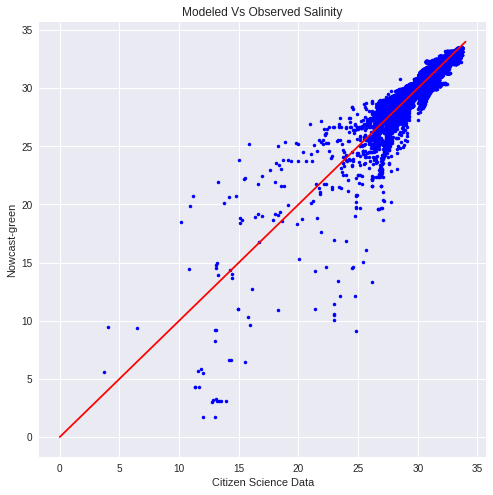

In [80]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(salinity2, list_of_sals2, 'b.')
ax.plot(np.arange(0,35), np.arange(0,35), 'r-')
ax.set_ylabel('Nowcast-green')
ax.set_xlabel('Citizen Science Data')
ax.set_title('Modeled Vs Observed Salinity')
ax.grid('on')

In [81]:
print('bias =  ' + str(np.mean(salinity2) - np.mean(list_of_sals2)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_sals2 - salinity2)**2) / len(list_of_sals2))))
xbar = np.mean(salinity2)
print('Willmott = ' + str(1-(np.sum((list_of_sals2 - salinity2)**2)  / 
                             np.sum((np.abs(list_of_sals2 - xbar) + np.abs(salinity2 - xbar))**2))))

bias =  -0.104518836325
RMSE = 0.644380928445
Willmott = 0.952626739685


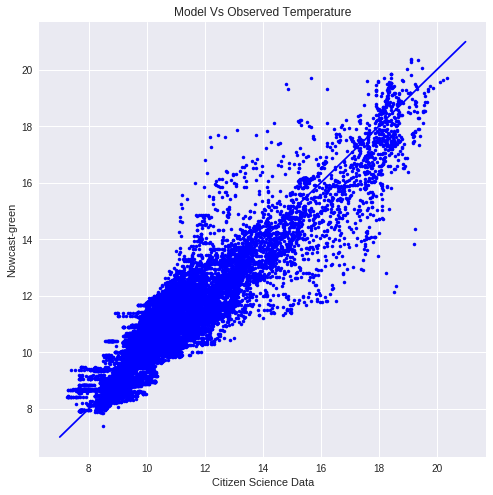

In [90]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(temperature2, list_of_temps2, 'b.')
ax.plot(np.arange(7,22), np.arange(7,22), 'b-')
ax.set_ylabel('Nowcast-green')
ax.set_xlabel('Citizen Science Data')
ax.set_title('Model Vs Observed Temperature')
ax.grid('on')

In [83]:
print('bias =  ' + str(np.mean(temperature2) - np.mean(list_of_temps2)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_temps2 - temperature2)**2) / len(list_of_temps2))))
xbar = np.mean(temperature2)
print('Willmott = ' + str(1-(np.sum((list_of_temps2 - temperature2)**2)  / 
                             np.sum((np.abs(list_of_temps2 - xbar) + np.abs(temperature2 - xbar))**2))))

bias =  -0.00220248795601
RMSE = 0.600293449632
Willmott = 0.968769116303
